# Develop a model container for Gaussian location regression


## Model specific 
1. Implement the a model container 
    1. Implement the model formulation via Var(), Dist(), Param(), Lpred(), Model()
3. Start with Gaussian distribution 

In [17]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

# load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

In [18]:
df

,age,bmi
0,0.03,13.235289
1,0.04,12.438775
2,0.04,14.541775
3,0.04,11.773954
4,0.04,15.325614
...,...,...
7289,21.45,19.329493
7290,21.47,21.562722
7291,21.54,23.355726
7292,21.68,24.869006


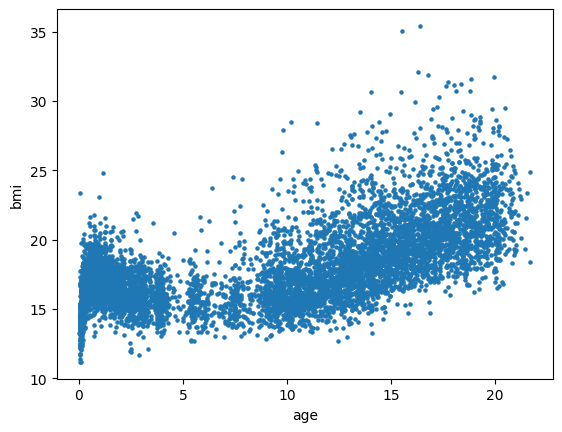

In [19]:
# plot the data
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [20]:
import sys
sys.path.append('../')

In [21]:
# test tigerpy
import tigerpy.model as tiger

# set up hyperparameters
beta_loc = tiger.Var(0, name="beta_loc")
beta_scale = tiger.Var(100, name="beta_scale")

# set up parameters 
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Var(0.01, name="a")
sigma_b = tiger.Var(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, name="sigma")

# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.fixed(X = df["age"].to_numpy())

# set up the linear predictor 
lpred = tiger.Lpred(X=X, name="loc", beta=beta)

# set up response distribution
y_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(y=df["bmi"].to_numpy(), distribution=y_dist)

In [22]:
m.log_lik

Array([-4.0973883, -3.9951394, -4.27884  , ..., -5.9489737, -6.313862 ,
       -4.904777 ], dtype=float32)

In [23]:
m.log_prior

Array(-18.020359, dtype=float32)

In [24]:
m.log_prob

Array(-35675.543, dtype=float32)

In [25]:
# test sampling with jax 
a = sigma.distribution.init_dist()
a.sample(seed=jax.random.PRNGKey(0))

Array(15.904469, dtype=float32)

# Compare current implementation to Liesel linear regression tut 

## Simulate data

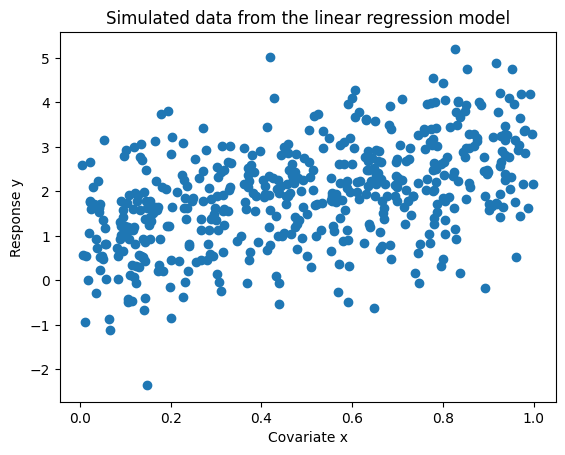

In [26]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
y_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, y_vec)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

In [29]:
# set up hyperparameters
beta_loc = tiger.Var(0, name="beta_loc")
beta_scale = tiger.Var(100, name="beta_scale")

# set up parameters 
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Var(0.01, name="a")
sigma_b = tiger.Var(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, name="sigma")

# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.fixed(X = x0)

# set up the linear predictor 
lpred = tiger.Lpred(X=X, name="loc", beta=beta)

# set up response distribution
y_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(y=y_vec, distribution=y_dist)

In [30]:
m.log_prob

Array(-1641.4343, dtype=float32)

In [31]:
m.log_prior

Array(-18.020359, dtype=float32)